# Inferring rate parameters

In [42]:
library(R2jags)
library(ggplot2)

We will now consider some more examples in which we want to estimate rate parameters.

## Example 1: Bernoulli trials

We will start by flipping a coin:

In [43]:
true_theta <- 0.6

coin_flips <- rbinom(n = 100, size = 1, prob = true_theta)

head(coin_flips, 20)

 [1] 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1

In [44]:
modelstr <- "
model{
  for (i in 1:length(y)) { 
    y[i] ~ dbern(theta)
    }
    theta ~ dbeta(99, 33)
}"

In [45]:
jagsdata <- list(y = coin_flips)

In [46]:
inits <- function() {
    list(theta = rbeta(1, 1, 1))
    }

In [47]:
parameters <- "theta"

In [48]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 103

Initializing model



In [49]:
fit

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
theta      0.698   0.031   0.636   0.678   0.700   0.719   0.755 1.001  1900
deviance 134.428   2.074 131.822 132.840 134.016 135.545 139.474 1.003  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 2.2 and DIC = 136.6
DIC is an estimate of expected predictive error (lower deviance is better).

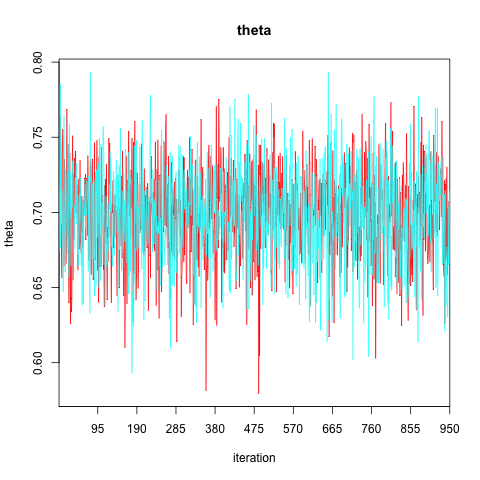

In [50]:
traceplot(fit, varname = "theta")

In [51]:
samples <- fit$BUGSoutput$sims.list
theta <- samples$theta
head(theta)

          [,1]
[1,] 0.7125588
[2,] 0.6974664
[3,] 0.6853859
[4,] 0.6813612
[5,] 0.6753005
[6,] 0.6571099

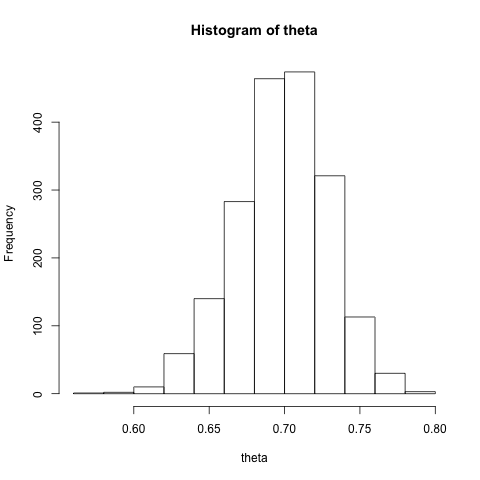

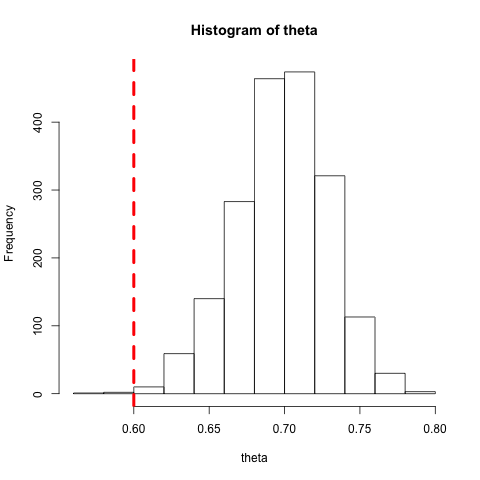

In [52]:
hist(theta)
abline(v = true_theta, col = "red", lty = 2, lwd = 4)

## Example 2: estimating a common rate

Now, suppose we have 20 people answering questions in our test, and we would like to infer a common ability.

In [53]:
true_ability <- 0.75

n_questions <- 10

answers <- rbinom(n = 20, size = n_questions, prob = true_ability)
answers

 [1]  7  4  4  8  6  7  8  7  9  8  6  8  8  7  8  5  9 10  8  8

In [54]:
modelstr <- "
model{
  for (i in 1:n_obs) { 
    y[i] ~ dbinom(theta, n)
    }
    theta ~ dbeta(1, 1)
}"

In [55]:
jagsdata <- list(y = answers, n = n_questions, n_obs = length(answers))

In [56]:
inits <- function() {
    list(theta = rbeta(1, 1, 1))
    }

In [57]:
parameters <- "theta"

In [58]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 24

Initializing model



In [59]:
print(fit)

Inference for Bugs model at "4", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect   2.5%    25%    50%    75%  97.5%  Rhat n.eff
theta      0.722   0.033  0.654  0.700  0.722  0.746  0.783 1.002  1100
deviance  74.103   1.569 73.016 73.139 73.534 74.370 78.564 1.001  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 1.2 and DIC = 75.3
DIC is an estimate of expected predictive error (lower deviance is better).


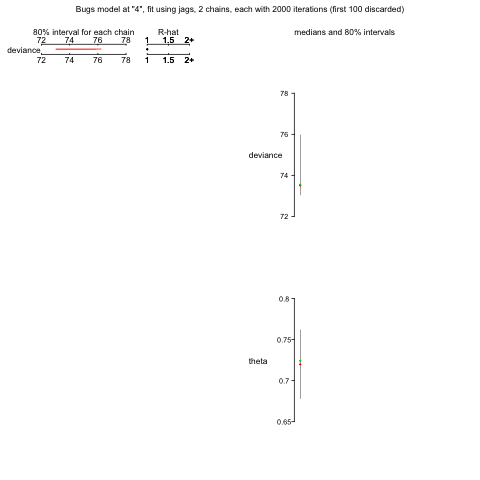

In [60]:
plot(fit)

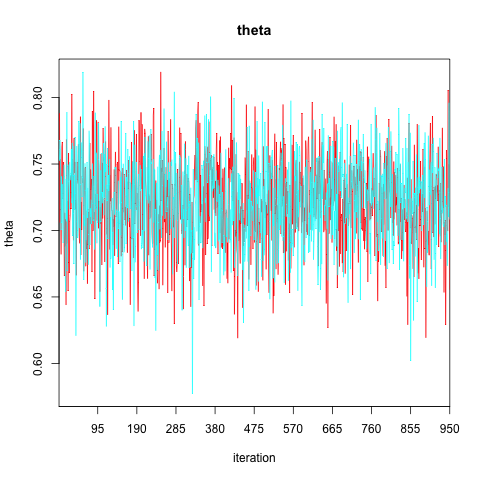

In [61]:
traceplot(fit, varname = "theta")

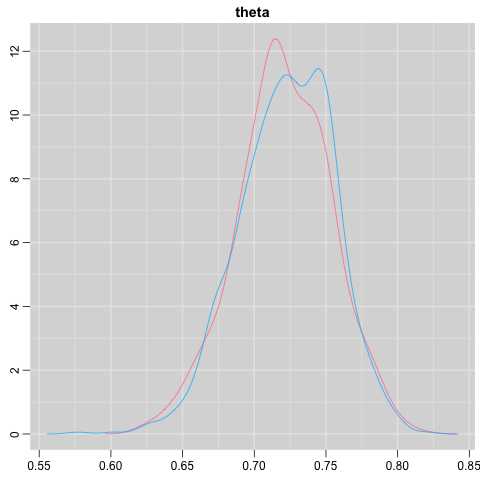

In [62]:
library(mcmcplots)
denplot(fit, parms = "theta")

## Example 3: comparing two rates

In this example, suppose we have 40 people from 2 groups answering questions in our test, and we would like to infer a common ability for each group, and we would like to know whether there is a difference between the groups.

In [63]:
group1_ability <- 0.8
group2_ability <- 0.75

n_questions <- 10

group1_answers <- rbinom(n = 20, size = n_questions, prob = group1_ability)
group2_answers <- rbinom(n = 20, size = n_questions, prob = group2_ability)

In [64]:
library(ggplot2)
library(tidyr)
library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [65]:
df <- data.frame(group1 = group1_answers, group2 = group2_answers)
df <- df %>% gather(group, answers, one_of(c("group1", "group2")))
df %>% head(10)

    group answers
1  group1      10
2  group1       8
3  group1       9
4  group1       8
5  group1      10
6  group1       9
7  group1       8
8  group1       9
9  group1       7
10 group1       7

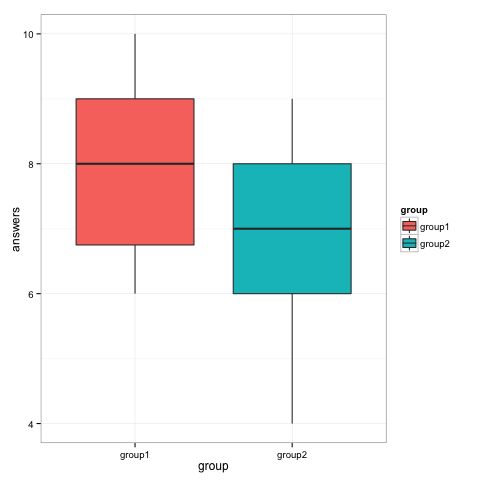

In [66]:
p <- ggplot(df, aes(x = group, y = answers, fill = group)) + theme_bw()
p + geom_boxplot()

In [67]:
modelstr <- "
model{
  for (i in 1:n_obs) { 

    # nested indexing
    y[i] ~ dbinom(theta[group[i]], n)
    }
  for (j in 1:n_groups) {
    theta[j] ~ dbeta(1, 1)
    }
    
  delta <- theta[1] - theta[2]
}"

In [68]:
df$group_idx <- match(df$group, unique(df$group))
df %>% head()
df %>% tail()

   group answers group_idx
1 group1      10         1
2 group1       8         1
3 group1       9         1
4 group1       8         1
5 group1      10         1
6 group1       9         1

    group answers group_idx
35 group2       7         2
36 group2       4         2
37 group2       9         2
38 group2       9         2
39 group2       6         2
40 group2       7         2

In [69]:
jagsdata <- list(y = df$answers, 
                 n = n_questions, 
                 n_obs = length(df$answers),
                 group = df$group_idx,
                 n_groups = length(unique(df$group)))

In [70]:
inits <- function() {
    list(theta = rbeta(jagsdata$n_groups, 1, 1))
    }

In [71]:
parameters <- c("theta", "delta")

In [72]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 87

Initializing model



In [73]:
print(fit)

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
delta      0.088   0.044   0.004   0.059   0.089   0.118   0.171 1.000  1900
theta[1]   0.786   0.029   0.730   0.767   0.787   0.806   0.842 1.002   920
theta[2]   0.699   0.033   0.633   0.676   0.700   0.721   0.762 1.002  1000
deviance 140.935   2.011 138.961 139.503 140.327 141.755 146.207 1.001  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 2.0 and DIC = 143.0
DIC is an estimate of expected predictive error (lower deviance is better).


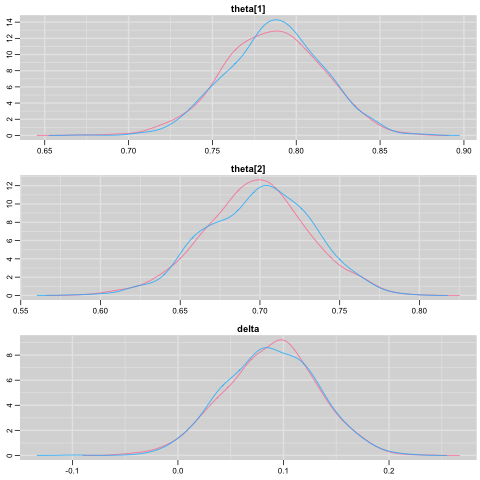

In [74]:
denplot(fit, parms = c("theta", "delta"))

In [75]:
samples <- fit$BUGSoutput$sims.list
theta <- as.data.frame(samples$theta)
colnames(theta) <- c("group1", "group2")
head(theta)

     group1    group2
1 0.8027950 0.6841924
2 0.7934323 0.6568290
3 0.7988580 0.6796466
4 0.7679021 0.7467257
5 0.7737730 0.7690074
6 0.7503686 0.6529381

### Plot posterior $\theta$ estimates

In [76]:
theta <- theta %>% gather(group, theta, one_of(c("group1", "group2")))

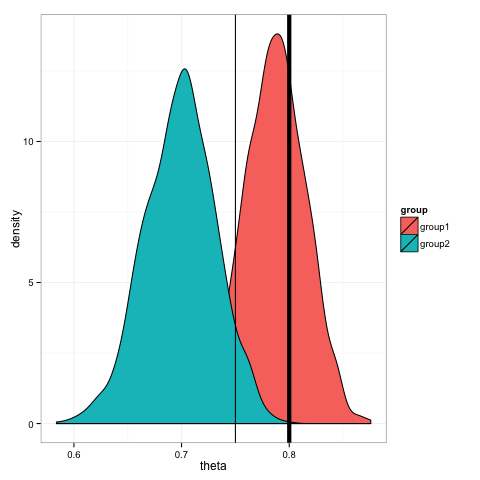

In [77]:
theta_post <- ggplot(theta, aes(x = theta,
                                fill = group)) + theme_bw()
theta_post + geom_density() +
             geom_vline(xintercept = group1_ability, size = 2) +
             geom_vline(xintercept = group2_ability)

### Plot posterior $\delta$ estimates

In [78]:
delta <- as.data.frame(samples$delta)
colnames(delta) <- "delta"

q <- quantile(delta$delta, c(0.05, 0.975))
delta_mean <- colMeans(delta)
delta_mean

     delta 
0.08788665 

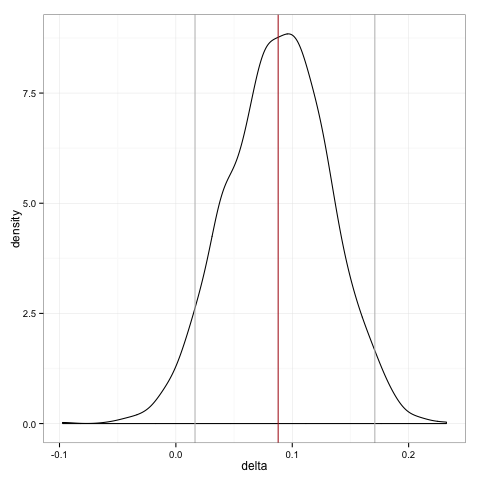

In [79]:
delta_post <- ggplot(delta, aes(x = delta)) + theme_bw()
delta_post + geom_density() +
             geom_vline(xintercept = q[1], color = "grey75") +
             geom_vline(xintercept = q[2], color = "grey75") + 
             geom_vline(xintercept = delta_mean, color = "firebrick")

In [82]:
100*(1-mean(delta[delta>0]))

[1] 90.99299

We can conclude that the difference between the two groups' ability parameters is credibly greater than 0.